In [9]:
# pre-processing data
import os
import random
from PIL import Image

# define path
data_folder = './project_files/data'
output_folder = './dataset/dataset'
output_size = (100, 100)

# Create output folder
os.makedirs(output_folder, exist_ok=True)

# Gets a list of subfolders
subfolders = [folder for folder in os.listdir(data_folder) if os.path.isdir(os.path.join(data_folder, folder))]

# Interate the folders for each class
for folder in subfolders:
    class_folder = os.path.join(data_folder, folder)
    output_class_folder = os.path.join(output_folder, folder)
    os.makedirs(output_class_folder, exist_ok=True)

    images = os.listdir(class_folder)

    # Save original picture
    for image_name in images:
        image_path = os.path.join(class_folder, image_name)
        img = Image.open(image_path)

        # Save original picture
        original_path = os.path.join(output_class_folder, image_name)
        # Center cutting
        width, height = img.size
        left = (width - output_size[0]) // 2
        top = (height - output_size[1]) // 2
        right = (width + output_size[0]) // 2
        bottom = (height + output_size[1]) // 2
        img = img.crop((left, top, right, bottom))
        img.save(original_path)

        # Rotate and resize
        for i in range(3):  # 旋转3次
            rotated_img = img.rotate(random.randint(0, 360))
            resized_img = rotated_img.resize(output_size)

            # 保存变换后的图片
            transformed_image_name = image_name.split('.')[0] + f'_transformed_{i + 1}.png'
            transformed_path = os.path.join(output_class_folder, transformed_image_name)
            resized_img.save(transformed_path)
print("File processed successfully")

File processed successfully


In [10]:
# Split train set and test set
import os
import shutil
import random

# Define path
dataset_folder = './dataset/dataset'
train_folder = './dataset/train'
test_folder = './dataset/test'

# Create the train and test folders
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Gets a list of subfolders
subfolders = [folder for folder in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, folder))]

# Iterate the folders for each class
for folder in subfolders:
    class_folder = os.path.join(dataset_folder, folder)
    train_class_folder = os.path.join(train_folder, folder)
    test_class_folder = os.path.join(test_folder, folder)
    os.makedirs(train_class_folder, exist_ok=True)
    os.makedirs(test_class_folder, exist_ok=True)
    
    images = os.listdir(class_folder)
    
    # split data to train and test
    random.shuffle(images)
    split_index = int(0.8 * len(images))
    train_images = images[:split_index]
    test_images = images[split_index:]
    
    # Copy train data to the train folder
    for image_name in train_images:
        src = os.path.join(class_folder, image_name)
        dst = os.path.join(train_class_folder, image_name)
        shutil.copyfile(src, dst)
    
    # Copy test data to the test folder
    for image_name in test_images:
        src = os.path.join(class_folder, image_name)
        dst = os.path.join(test_class_folder, image_name)
        shutil.copyfile(src, dst)
print("Generated training set and test set successfully")

In [11]:
# Build ResNet model and train it
import os
import sys
import json
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1, downsample=None, **kwargs):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel,
                               kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel,
                               kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, in_channel, out_channel, stride=1, downsample=None,
                 groups=1, width_per_group=64):
        super(Bottleneck, self).__init__()

        width = int(out_channel * (width_per_group / 64.)) * groups

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=width,
                               kernel_size=1, stride=1, bias=False)  # squeeze channels
        self.bn1 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv2 = nn.Conv2d(in_channels=width, out_channels=width, groups=groups,
                               kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn2 = nn.BatchNorm2d(width)
        # -----------------------------------------
        self.conv3 = nn.Conv2d(in_channels=width, out_channels=out_channel*self.expansion,
                               kernel_size=1, stride=1, bias=False)  # unsqueeze channels
        self.bn3 = nn.BatchNorm2d(out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self,
                 block,
                 blocks_num,
                 num_classes=10,
                 include_top=True,
                 groups=1,
                 width_per_group=64):
        super(ResNet, self).__init__()
        self.include_top = include_top
        self.in_channel = 64

        self.groups = groups
        self.width_per_group = width_per_group

        self.conv1 = nn.Conv2d(3, self.in_channel, kernel_size=7, stride=2,
                               padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, blocks_num[0])
        self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)
        self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
        self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
        if self.include_top:
            self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # output size = (1, 1)
            self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None
        if stride != 1 or self.in_channel != channel * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channel, channel * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(channel * block.expansion))

        layers = []
        layers.append(block(self.in_channel,
                            channel,
                            downsample=downsample,
                            stride=stride,
                            groups=self.groups,
                            width_per_group=self.width_per_group))
        self.in_channel = channel * block.expansion

        for _ in range(1, block_num):
            layers.append(block(self.in_channel,
                                channel,
                                groups=self.groups,
                                width_per_group=self.width_per_group))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        if self.include_top:
            x = self.avgpool(x)
            x = torch.flatten(x, 1)
            x = self.fc(x)

        return x

def resnet34(num_classes=10, include_top=True):
    # https://download.pytorch.org/models/resnet34-333f7ec4.pth
    return ResNet(BasicBlock, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet50(num_classes=10, include_top=True):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes=num_classes, include_top=include_top)


def resnet101(num_classes=10, include_top=True):
    return ResNet(Bottleneck, [3, 4, 23, 3], num_classes=num_classes, include_top=include_top)


def resnext50_32x4d(num_classes=10, include_top=True):
    groups = 32
    width_per_group = 4
    return ResNet(Bottleneck, [3, 4, 6, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


def resnext101_32x8d(num_classes=10, include_top=True):
    groups = 32
    width_per_group = 8
    return ResNet(Bottleneck, [3, 4, 23, 3],
                  num_classes=num_classes,
                  include_top=include_top,
                  groups=groups,
                  width_per_group=width_per_group)


# 定义训练验证函数
def train_and_val(epochs, model, train_loader, val_loader, criterion, optimizer):
    torch.cuda.empty_cache()
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    best_acc = 0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        training_acc = 0
        with tqdm(total=len(train_loader)) as pbar:
            for image, label in train_loader:
                # training phase

                #                 images, labels = data
                #             optimizer.zero_grad()
                #             logits = net(images.to(device))
                #             loss = loss_function(logits, labels.to(device))
                #             loss.backward()
                #             optimizer.step()

                model.train()
                optimizer.zero_grad()
                image = image.to(device)
                label = label.to(device)
                # forward
                output = model(image)
                loss = criterion(output, label)
                predict_t = torch.max(output, dim=1)[1]

                # backward
                loss.backward()
                optimizer.step()  # update weight

                running_loss += loss.item()
                training_acc += torch.eq(predict_t, label).sum().item()
                pbar.update(1)

        model.eval()
        val_losses = 0
        validation_acc = 0
        # validation loop
        with torch.no_grad():
            with tqdm(total=len(val_loader)) as pb:
                for image, label in val_loader:
                    image = image.to(device)
                    label = label.to(device)
                    output = model(image)

                    # loss
                    loss = criterion(output, label)
                    predict_v = torch.max(output, dim=1)[1]

                    val_losses += loss.item()
                    validation_acc += torch.eq(predict_v, label).sum().item()
                    pb.update(1)

            # calculatio mean for each batch
            train_loss.append(running_loss / len(train_dataset))
            val_loss.append(val_losses / len(val_dataset))

            train_acc.append(training_acc / len(train_dataset))
            val_acc.append(validation_acc / len(val_dataset))
            
            torch.save(model, "last.pth")
            if best_acc<(validation_acc / len(val_dataset)):
                torch.save(model, "best.pth")
            

            print("Epoch:{}/{}..".format(e + 1, epochs),
                  "Train Acc: {:.3f}..".format(training_acc / len(train_dataset)),
                  "Val Acc: {:.3f}..".format(validation_acc / len(val_dataset)),
                  "Train Loss: {:.3f}..".format(running_loss / len(train_dataset)),
                  "Val Loss: {:.3f}..".format(val_losses / len(val_dataset)),
                  "Time: {:.2f}s".format((time.time() - since)))
            

    history = {'train_loss': train_loss, 'val_loss': val_loss,'train_acc': train_acc, 'val_acc': val_acc}
    print('Total time: {:.2f} m'.format((time.time() - fit_time) / 60))
    
    return history

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("using {} device.".format(device))

BATCH_SIZE = 16

# 设置训练集和验证集
data_transform = {
    "train": transforms.Compose([transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
    "val": transforms.Compose([transforms.Resize(256),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

train_dataset = datasets.ImageFolder("./dataset/train/", transform=data_transform["train"])  # Training dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                                           num_workers=2)  # Load data

val_dataset = datasets.ImageFolder("./dataset/test", transform=data_transform["val"])  # Test dataset
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                                         num_workers=2)  # Load data


# training
net = resnet34()
loss_function = nn.CrossEntropyLoss()  # set loss function
optimizer = optim.Adam(net.parameters(), lr=0.0001)  # Set optimizer and learning rate
epoch = 60

history = train_and_val(epoch, net, train_loader, val_loader, loss_function, optimizer)


using cuda:0 device.


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:1/60.. Train Acc: 0.291.. Val Acc: 0.317.. Train Loss: 0.121.. Val Loss: 0.137.. Time: 30.63s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:2/60.. Train Acc: 0.476.. Val Acc: 0.553.. Train Loss: 0.088.. Val Loss: 0.070.. Time: 23.87s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:3/60.. Train Acc: 0.558.. Val Acc: 0.465.. Train Loss: 0.076.. Val Loss: 0.084.. Time: 25.58s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:4/60.. Train Acc: 0.621.. Val Acc: 0.733.. Train Loss: 0.064.. Val Loss: 0.041.. Time: 28.41s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:5/60.. Train Acc: 0.650.. Val Acc: 0.659.. Train Loss: 0.060.. Val Loss: 0.055.. Time: 31.20s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:6/60.. Train Acc: 0.672.. Val Acc: 0.812.. Train Loss: 0.056.. Val Loss: 0.031.. Time: 31.89s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:7/60.. Train Acc: 0.695.. Val Acc: 0.752.. Train Loss: 0.052.. Val Loss: 0.039.. Time: 36.94s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:8/60.. Train Acc: 0.714.. Val Acc: 0.785.. Train Loss: 0.049.. Val Loss: 0.035.. Time: 39.66s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:9/60.. Train Acc: 0.739.. Val Acc: 0.752.. Train Loss: 0.045.. Val Loss: 0.036.. Time: 40.56s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:10/60.. Train Acc: 0.720.. Val Acc: 0.826.. Train Loss: 0.048.. Val Loss: 0.028.. Time: 44.47s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:11/60.. Train Acc: 0.742.. Val Acc: 0.716.. Train Loss: 0.045.. Val Loss: 0.044.. Time: 43.84s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:12/60.. Train Acc: 0.768.. Val Acc: 0.761.. Train Loss: 0.041.. Val Loss: 0.037.. Time: 46.68s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:13/60.. Train Acc: 0.774.. Val Acc: 0.826.. Train Loss: 0.040.. Val Loss: 0.025.. Time: 52.53s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:14/60.. Train Acc: 0.770.. Val Acc: 0.793.. Train Loss: 0.039.. Val Loss: 0.036.. Time: 54.01s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:15/60.. Train Acc: 0.785.. Val Acc: 0.931.. Train Loss: 0.038.. Val Loss: 0.012.. Time: 50.74s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:16/60.. Train Acc: 0.786.. Val Acc: 0.901.. Train Loss: 0.037.. Val Loss: 0.018.. Time: 52.52s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:17/60.. Train Acc: 0.787.. Val Acc: 0.807.. Train Loss: 0.037.. Val Loss: 0.034.. Time: 44.75s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:18/60.. Train Acc: 0.799.. Val Acc: 0.878.. Train Loss: 0.035.. Val Loss: 0.021.. Time: 46.22s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:19/60.. Train Acc: 0.814.. Val Acc: 0.841.. Train Loss: 0.034.. Val Loss: 0.026.. Time: 43.13s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:20/60.. Train Acc: 0.816.. Val Acc: 0.845.. Train Loss: 0.033.. Val Loss: 0.026.. Time: 51.19s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:21/60.. Train Acc: 0.825.. Val Acc: 0.884.. Train Loss: 0.031.. Val Loss: 0.020.. Time: 55.85s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:22/60.. Train Acc: 0.822.. Val Acc: 0.783.. Train Loss: 0.031.. Val Loss: 0.035.. Time: 60.83s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:23/60.. Train Acc: 0.820.. Val Acc: 0.926.. Train Loss: 0.032.. Val Loss: 0.014.. Time: 59.64s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:24/60.. Train Acc: 0.834.. Val Acc: 0.848.. Train Loss: 0.031.. Val Loss: 0.030.. Time: 56.07s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:25/60.. Train Acc: 0.831.. Val Acc: 0.845.. Train Loss: 0.030.. Val Loss: 0.026.. Time: 52.03s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:26/60.. Train Acc: 0.838.. Val Acc: 0.870.. Train Loss: 0.028.. Val Loss: 0.022.. Time: 52.11s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:27/60.. Train Acc: 0.819.. Val Acc: 0.871.. Train Loss: 0.032.. Val Loss: 0.022.. Time: 56.77s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:28/60.. Train Acc: 0.840.. Val Acc: 0.918.. Train Loss: 0.028.. Val Loss: 0.016.. Time: 49.34s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:29/60.. Train Acc: 0.839.. Val Acc: 0.948.. Train Loss: 0.027.. Val Loss: 0.009.. Time: 48.37s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:30/60.. Train Acc: 0.852.. Val Acc: 0.710.. Train Loss: 0.026.. Val Loss: 0.070.. Time: 47.62s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:31/60.. Train Acc: 0.847.. Val Acc: 0.962.. Train Loss: 0.026.. Val Loss: 0.006.. Time: 46.41s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:32/60.. Train Acc: 0.873.. Val Acc: 0.965.. Train Loss: 0.023.. Val Loss: 0.006.. Time: 50.44s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:33/60.. Train Acc: 0.865.. Val Acc: 0.932.. Train Loss: 0.025.. Val Loss: 0.011.. Time: 50.54s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:34/60.. Train Acc: 0.849.. Val Acc: 0.900.. Train Loss: 0.026.. Val Loss: 0.019.. Time: 44.63s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:35/60.. Train Acc: 0.864.. Val Acc: 0.948.. Train Loss: 0.024.. Val Loss: 0.008.. Time: 44.23s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:36/60.. Train Acc: 0.873.. Val Acc: 0.380.. Train Loss: 0.022.. Val Loss: 0.506.. Time: 46.39s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:37/60.. Train Acc: 0.866.. Val Acc: 0.490.. Train Loss: 0.024.. Val Loss: 0.333.. Time: 45.56s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:38/60.. Train Acc: 0.861.. Val Acc: 0.929.. Train Loss: 0.024.. Val Loss: 0.012.. Time: 51.71s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:39/60.. Train Acc: 0.854.. Val Acc: 0.972.. Train Loss: 0.026.. Val Loss: 0.006.. Time: 50.66s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:40/60.. Train Acc: 0.876.. Val Acc: 0.925.. Train Loss: 0.021.. Val Loss: 0.013.. Time: 47.00s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:41/60.. Train Acc: 0.878.. Val Acc: 0.928.. Train Loss: 0.023.. Val Loss: 0.013.. Time: 51.04s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:42/60.. Train Acc: 0.871.. Val Acc: 0.929.. Train Loss: 0.022.. Val Loss: 0.012.. Time: 49.84s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:43/60.. Train Acc: 0.889.. Val Acc: 0.954.. Train Loss: 0.021.. Val Loss: 0.009.. Time: 49.67s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:44/60.. Train Acc: 0.875.. Val Acc: 0.940.. Train Loss: 0.023.. Val Loss: 0.010.. Time: 44.58s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:45/60.. Train Acc: 0.879.. Val Acc: 0.972.. Train Loss: 0.021.. Val Loss: 0.005.. Time: 48.88s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:46/60.. Train Acc: 0.882.. Val Acc: 0.959.. Train Loss: 0.021.. Val Loss: 0.006.. Time: 49.69s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:47/60.. Train Acc: 0.894.. Val Acc: 0.928.. Train Loss: 0.019.. Val Loss: 0.013.. Time: 44.26s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:48/60.. Train Acc: 0.879.. Val Acc: 0.926.. Train Loss: 0.021.. Val Loss: 0.013.. Time: 47.55s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:49/60.. Train Acc: 0.873.. Val Acc: 0.925.. Train Loss: 0.023.. Val Loss: 0.012.. Time: 45.53s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:50/60.. Train Acc: 0.889.. Val Acc: 0.221.. Train Loss: 0.021.. Val Loss: 1.159.. Time: 42.64s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:51/60.. Train Acc: 0.885.. Val Acc: 0.954.. Train Loss: 0.020.. Val Loss: 0.008.. Time: 46.30s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:52/60.. Train Acc: 0.896.. Val Acc: 0.934.. Train Loss: 0.019.. Val Loss: 0.011.. Time: 46.77s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:53/60.. Train Acc: 0.887.. Val Acc: 0.936.. Train Loss: 0.019.. Val Loss: 0.013.. Time: 46.59s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:54/60.. Train Acc: 0.893.. Val Acc: 0.948.. Train Loss: 0.019.. Val Loss: 0.008.. Time: 48.25s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:55/60.. Train Acc: 0.873.. Val Acc: 0.943.. Train Loss: 0.022.. Val Loss: 0.009.. Time: 49.43s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:56/60.. Train Acc: 0.890.. Val Acc: 0.975.. Train Loss: 0.018.. Val Loss: 0.005.. Time: 49.29s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:57/60.. Train Acc: 0.895.. Val Acc: 0.749.. Train Loss: 0.019.. Val Loss: 0.080.. Time: 45.44s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:58/60.. Train Acc: 0.895.. Val Acc: 0.959.. Train Loss: 0.018.. Val Loss: 0.009.. Time: 49.36s


  0%|                                                                                          | 0/159 [00:00<?, ?it/s]

Epoch:59/60.. Train Acc: 0.887.. Val Acc: 0.976.. Train Loss: 0.020.. Val Loss: 0.005.. Time: 48.47s


100%|██████████████████████████████████████████████████████████████████████████████████| 40/40 [00:03<00:00, 10.39it/s]


Epoch:60/60.. Train Acc: 0.885.. Val Acc: 0.934.. Train Loss: 0.021.. Val Loss: 0.012.. Time: 45.89s
Total time: 46.41 m


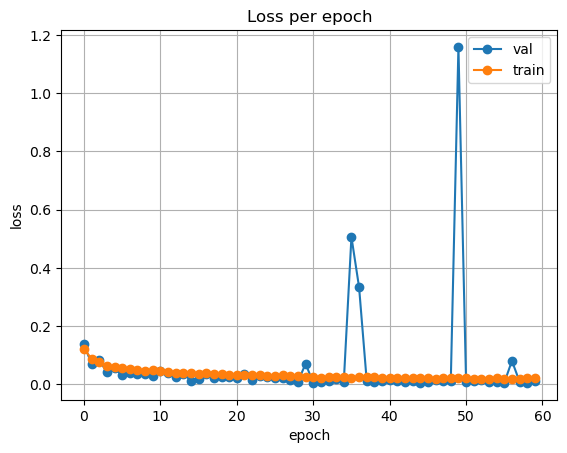

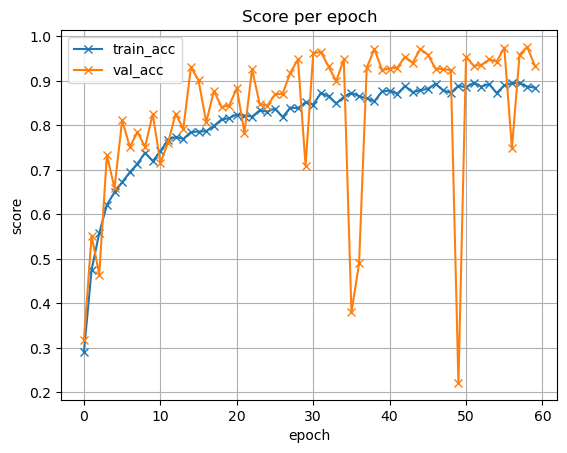

In [12]:
def plot_loss(x, history):
    plt.plot(x, history['val_loss'], label='val', marker='o')
    plt.plot(x, history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()


def plot_acc(x, history):
    plt.plot(x, history['train_acc'], label='train_acc', marker='x')
    plt.plot(x, history['val_acc'], label='val_acc', marker='x')
    plt.title('Score per epoch')
    plt.ylabel('score')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

plot_loss(np.arange(0,epoch), history)
plot_acc(np.arange(0,epoch), history)


In [15]:
# Output the accuracy of each type of font
classes = ('AguafinaScript', 'AlexBrush', 'Allura', 'alsscrp', 'Canterbury', 'GreatVibes', 'Holligate Signature', 'I Love Glitter', 'James Fajardo', 'OpenSans')

class_correct = [0.] * 10
class_total = [0.] * 10 
y_test, y_pred = [] , []
X_test = []

with torch.no_grad():
    for images, labels in val_loader:
        X_test.extend([_ for _ in images])
        outputs = net(images.to(device))
        _, predicted = torch.max(outputs, 1)
        predicted = predicted.cpu()
        c = (predicted == labels).squeeze()
        for i, label in enumerate(labels):
            class_correct[label] += c[i].item()
            class_total[label] += 1
        y_pred.extend(predicted.numpy())
        y_test.extend(labels.cpu().numpy())      
        
for i in range(10):
    print(f"Acuracy of {classes[i]:5s}: {100*class_correct[i]/class_total[i]:2.0f}%")


Acuracy of AguafinaScript: 97%
Acuracy of AlexBrush: 92%
Acuracy of Allura: 88%
Acuracy of alsscrp: 98%
Acuracy of Canterbury: 95%
Acuracy of GreatVibes: 97%
Acuracy of Holligate Signature: 100%
Acuracy of I Love Glitter: 98%
Acuracy of James Fajardo: 97%
Acuracy of OpenSans: 77%


In [17]:
# Check precision, recall, and f1-score
from sklearn.metrics import confusion_matrix, classification_report

ac = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
cr = classification_report(y_test, y_pred, target_names=classes)
print("Accuracy is :",ac) 
print(cr)


Accuracy is : 0.9340659340659341
                     precision    recall  f1-score   support

     AguafinaScript       1.00      0.97      0.98        67
          AlexBrush       0.91      0.92      0.91        63
             Allura       0.89      0.88      0.88        56
            alsscrp       1.00      0.98      0.99        61
         Canterbury       0.69      0.95      0.80        61
         GreatVibes       1.00      0.97      0.98        66
Holligate Signature       0.94      1.00      0.97        58
     I Love Glitter       1.00      0.98      0.99        64
      James Fajardo       1.00      0.97      0.98        59
           OpenSans       1.00      0.77      0.87        82

           accuracy                           0.93       637
          macro avg       0.94      0.94      0.94       637
       weighted avg       0.95      0.93      0.94       637



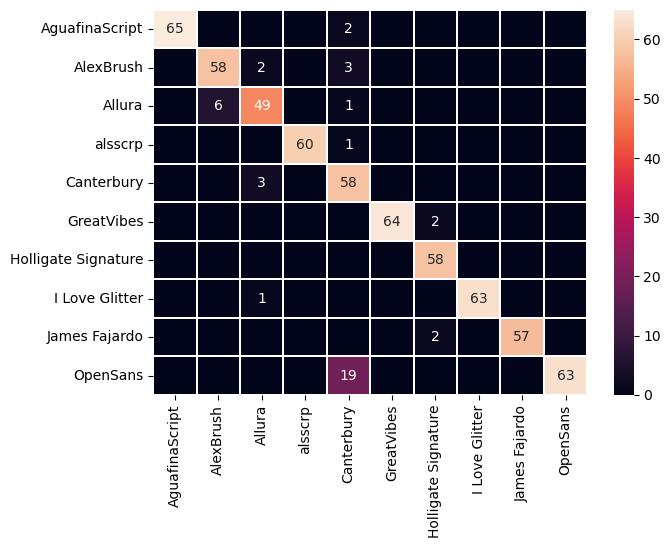

In [18]:
# Check confusion matrix
import seaborn as sns, pandas as pd

labels = pd.DataFrame(cm).applymap(lambda v: f"{v}" if v!=0 else f"")
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=labels, fmt='s', xticklabels=classes, yticklabels=classes, linewidths=0.1 )
plt.show()
